In [2]:
# Importations nécessaires
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Pour la modélisation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------------
# 1. Chargement des datasets
# -------------------------------

# Chargement du dataset des transactions immobilières.
# Remplacez 'transactions.csv' par le chemin vers votre fichier.
df_transactions = pd.read_csv(r'data\data_frame_maison.csv', parse_dates=['date_mutation'])
print("Dataset transactions:", df_transactions.head())

# Chargement du dataset des indicateurs macroéconomiques.
# Remplacez 'indicators.csv' par le chemin vers votre fichier.
# Le paramètre `sep=';'` permet de gérer le séparateur point-virgule et `decimal=','`
# indique que les nombres décimaux utilisent la virgule.
df_indicateurs = pd.read_csv(r'data/data_economie_global/df_final.csv', sep=';', decimal=',', parse_dates=['Date'])
print("\nDataset indicateurs:", df_indicateurs.head())


C:\Users\mathe\AppData\Local\Temp\ipykernel_13296\1035799154.py:18: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv(r'data\data_frame_maison.csv', parse_dates=['date_mutation'])


Dataset transactions:    Unnamed: 0 date_mutation nature_mutation  valeur_fonciere  code_postal  \
0           0    2020-05-22           Vente         311000.0       1700.0   
1           1    2022-03-22           Vente         139500.0       1150.0   
2           2    2022-05-05           Vente         240000.0       1400.0   
3           3    2019-09-25           Vente         292000.0       1480.0   
4           4    2019-09-11           Vente         516500.0       1340.0   

  code_commune         nom_commune code_departement nature_culture  \
0         1249             Miribel                1           sols   
1         1202             Lagnieu                1           sols   
2         1272  Neuville-les-Dames                1           sols   
3         1194    Jassans-Riottier                1           sols   
4         1236           Marsonnas                1           prés   

   surface_terrain  longitude   latitude section_prefixe type_local  \
0            127.0   4.

In [4]:

# -------------------------------
# 2. Prétraitement et fusion des données
# -------------------------------

# Créer une clé temporelle 'year_month' pour les transactions
df_transactions['year_month'] = df_transactions['date_mutation'].dt.to_period('M')

# Pour le dataset des indicateurs, créer également une variable 'year_month'
df_indicateurs['year_month'] = df_indicateurs['Date'].dt.to_period('M')

# Fusionner les deux datasets sur la variable 'year_month'
# On utilise une jointure "left" pour garder toutes les transactions.
df_merged = pd.merge(df_transactions, df_indicateurs, on='year_month', how='left')
print("\nDataset fusionné (échantillon) :", df_merged.head())



Dataset fusionné (échantillon) :    Unnamed: 0 date_mutation nature_mutation  valeur_fonciere  code_postal  \
0           0    2020-05-22           Vente         311000.0       1700.0   
1           1    2022-03-22           Vente         139500.0       1150.0   
2           2    2022-05-05           Vente         240000.0       1400.0   
3           3    2019-09-25           Vente         292000.0       1480.0   
4           4    2019-09-11           Vente         516500.0       1340.0   

  code_commune         nom_commune code_departement nature_culture  \
0         1249             Miribel                1           sols   
1         1202             Lagnieu                1           sols   
2         1272  Neuville-les-Dames                1           sols   
3         1194    Jassans-Riottier                1           sols   
4         1236           Marsonnas                1           prés   

   surface_terrain  ...   latitude  section_prefixe type_local  \
0            127

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 13.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   36.3s



Performance du modèle Random Forest avec localisation:
MAE : 124557.31
RMSE : 1776113.80


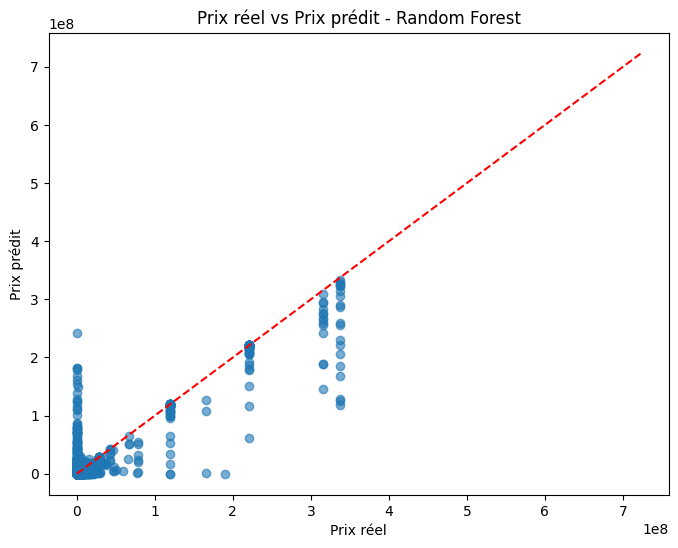

In [6]:
# Importation supplémentaire nécessaire
from sklearn.ensemble import RandomForestRegressor

# Définir la variable cible
cible = 'valeur_fonciere'

# Sélectionner les features pertinentes, incluant explicitement la localisation
features_rf = [
    'surface_terrain',
    'surface_reelle_bati',
    'longitude',
    'latitude',
    "Crédits à l'habitat hors renégociations",
    "Taux hors renégociations",
    "Variations d'encours mensuelles cvs",
    "IPC"
]

# Retirer les lignes avec valeurs manquantes dans ces colonnes
model_rf_data = df_merged.dropna(subset=features_rf + [cible])

# Séparation des données
X_rf = model_rf_data[features_rf]
y_rf = model_rf_data[cible]

# Train-test split
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)
rf_model.fit(X_rf_train, y_rf_train)

# Prédiction
rf_pred = rf_model.predict(X_rf_test)

# Évaluation
rf_mae = mean_absolute_error(y_rf_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_rf_test, rf_pred))

print("\nPerformance du modèle Random Forest avec localisation:")
print(f"MAE : {rf_mae:.2f}")
print(f"RMSE : {rf_rmse:.2f}")

# Visualisation résultats
plt.figure(figsize=(8, 6))
plt.scatter(y_rf_test, rf_pred, alpha=0.6)
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Prix réel vs Prix prédit - Random Forest")
plt.plot([y_rf.min(), y_rf.max()], [y_rf.min(), y_rf.max()], 'r--')
plt.show()

In [11]:
%pip install xgboost
import xgboost as xgb
# Importations
# --- À partir de df_merged ---
# Définir la variable cible
cible = 'valeur_fonciere'

# Sélection des features, incluant la localisation et les indicateurs macroéconomiques
features_xgb = [
    'surface_terrain',
    'surface_reelle_bati',
    'longitude',
    'latitude',
    "Crédits à l'habitat hors renégociations",
    "Taux hors renégociations",
    "Variations d'encours mensuelles cvs",
    "IPC"
]

# Retirer les lignes avec valeurs manquantes dans les colonnes sélectionnées et la cible
model_xgb_data = df_merged.dropna(subset=features_xgb + [cible])

# Séparation des variables explicatives (X) et de la cible (y)
X_xgb = model_xgb_data[features_xgb]
y_xgb = model_xgb_data[cible]

# Division en ensembles d'entraînement et de test
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

# Instanciation et entraînement du modèle XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_xgb_train, y_xgb_train)

# Prédictions sur l'ensemble de test
xgb_pred = xgb_model.predict(X_xgb_test)

# Évaluation du modèle avec MAE et RMSE
xgb_mae = mean_absolute_error(y_xgb_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_xgb_test, xgb_pred))

print("Performance du modèle XGBoost avec localisation et indicateurs macroéconomiques:")
print(f"MAE : {xgb_mae:.2f}")
print(f"RMSE : {xgb_rmse:.2f}")

# Visualisation des résultats : comparaison entre prix réel et prix prédit
plt.figure(figsize=(8, 6))
plt.scatter(y_xgb_test, xgb_pred, alpha=0.6)
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Prix réel vs Prix prédit - XGBoost")
plt.plot([y_xgb.min(), y_xgb.max()], [y_xgb.min(), y_xgb.max()], 'r--')
plt.show()



   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 1.7 MB/s eta 0:01:31
   ---------------------------------------- 1.7/150.0 MB 15.8 MB/s eta 0:00:10
   - -------------------------------------- 3.8/150.0 MB 24.3 MB/s eta 0:00:07
   - -------------------------------------- 5.9/150.0 MB 31.4 MB/s eta 0:00:05
   -- ------------------------------------- 8.1/150.0 MB 34.7 MB/s eta 0:00:05
   -- ------------------------------------- 10.3/150.0 MB 46.7 MB/s eta 0:00:03
   --- ------------------------------------ 12.4/150.0 MB 46.7 MB/s eta 0:00:03
   --- ------------------------------------ 14.6/150.0 MB 50.4 MB/s eta 0:00:03
   ---- ----------------------------------- 16.9/150.0 MB 50.4 MB/s eta 0:00:03
   ----- ---------------------------------- 19.6/150.0 MB 50.1 MB/s eta 0:00:03
   ----- ---------------------------------- 22.2/150.0 MB 54.7 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mathe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:IPC: object